In [1]:
import sys

sys.path.append("../")

In [2]:
import requests
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [3]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
# TIMEFRAME = '1h'
# lookback = 30*4

TIMEFRAME = '1m'
lookback = 20

In [4]:


LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(15)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(15)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, interval='1m'):
    batches = []

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= datetime.utcnow():
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df.set_index('open_time', inplace=True)
        df = df[~df.index.duplicated(keep='first')]
        return df



In [5]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTCUSDT',
 'ETHUSDT',
 'BCHUSDT',
 'XRPUSDT',
 'LTCUSDT',
 'ETCUSDT',
 'LINKUSDT',
 'XLMUSDT',
 'ADAUSDT',
 'BNBUSDT',
 'ATOMUSDT',
 'ALGOUSDT',
 'DOTUSDT',
 'SOLUSDT',
 'AVAXUSDT',
 'MATICUSDT',
 'XMRUSDT',
 'BCHUSDT',
 ]
symbols = [s.replace('USDT', '') for s in symbols]

data = []

for symbol in symbols:
    df = get_candles(base=symbol, quote='USDT', start_date=datetime.now() - timedelta(days=lookback), interval=TIMEFRAME)
    if df is None:
        continue

    df.rename(columns={'close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    log = np.log(df[symbol].astype(np.float32))
    data.append(log)

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTC,ETH,BCH,XRP,LTC,ETC,LINK,XLM,ADA,BNB,ATOM,ALGO,DOT,SOL,AVAX,MATIC,XMR,BCH
open_time,,,,,,,,,,,,,,,,,,
2022-11-20 03:28:00,9.721851,7.104432,4.655483,-0.940583,4.150568,2.972054,1.826322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-20 03:29:00,9.722044,7.104744,4.655768,-0.941096,4.150252,2.972566,1.825839,-2.398105,-1.109875,5.608556,2.299380,-1.254214,1.722945,2.550694,NaN,NaN,NaN,NaN
2022-11-20 03:30:00,9.722170,7.105237,4.656054,-0.940071,4.151512,2.972668,1.826322,-2.397995,-1.110786,5.608922,2.300182,-1.251763,1.723481,2.551085,2.561173,-0.136737,4.896645,4.656054
2022-11-20 03:31:00,9.722601,7.105729,4.656243,-0.940327,4.152456,2.972771,1.826966,-2.397336,-1.110786,5.609398,2.301384,-1.250715,1.723481,2.551474,2.561945,-0.135591,4.897840,4.656243
2022-11-20 03:32:00,9.722380,7.105368,4.656528,-0.939815,4.152142,2.972310,1.826483,-2.397336,-1.111394,5.609142,2.300583,-1.251763,1.723124,2.550850,2.561713,-0.136278,4.897989,4.656528


In [6]:
df.tail()

,BTC,ETH,BCH,XRP,LTC,ETC,LINK,XLM,ADA,BNB,ATOM,ALGO,DOT,SOL,AVAX,MATIC,XMR,BCH
open_time,,,,,,,,,,,,,,,,,,
2022-12-10 03:25:00,9.749077,7.141427,4.699389,-0.946750,4.335328,2.951467,1.921910,-2.457836,-1.166035,5.658576,2.271713,-1.480166,1.666007,2.611392,2.593611,-0.101258,5.004886,4.699389
2022-12-10 03:26:00,9.749065,7.141427,4.699662,-0.946492,4.335066,2.951362,1.922203,-2.457953,-1.166035,5.658611,2.271610,-1.479726,1.666196,2.611025,2.593611,-0.101147,5.004886,4.699662
2022-12-10 03:27:00,9.748966,7.141475,4.699662,-0.947266,4.334935,2.951624,1.922495,-2.457253,-1.166035,5.658855,2.271816,-1.479287,1.666007,2.611319,2.593761,-0.100926,5.004818,4.699844
2022-12-10 03:28:00,NaN,NaN,NaN,NaN,NaN,NaN,1.922642,-2.457603,-1.165714,5.658925,2.272023,-1.479287,1.666385,2.611392,2.594135,-0.100926,5.005086,4.700026
2022-12-10 03:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.611392,2.594135,-0.100705,5.005020,4.700117


In [7]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [8]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        try:
            hedge_ratio = coint_df.iloc[i]['hedge_ratio']
            _df = df.copy()
            spread = calculate_spread(_df, i, hedge_ratio)
                
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
        except:
            pass
    
    return pd.DataFrame(data)




In [9]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[57.94552821740493, -6.533550645604588]",BTC,LINK
1,"[139.7981551538644, -64.32324309478705]",BTC,MATIC
2,"[17.950268029883716, -18.162412406472935]",ETH,LTC
3,"[42.010100849381416, -21.77174783405928]",ETH,LINK
4,"[6.764657291842313, 22.39068142345486]",ETH,ALGO


In [10]:
coint_df.to_csv(f'coint_df_{TIMEFRAME}.csv')


In [11]:
stationary_df = find_stationary_portfolio()
stationary_df = pd.concat([stationary_df, coint_df], axis=1)
stationary_df.dropna(inplace=True)
stationary_df['i'] = stationary_df.i.astype('int64')
stationary_df['half_life'] = stationary_df.half_life.astype('int64')
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
stationary_df.to_csv(f'stationary_df_{TIMEFRAME}.csv')
stationary_df

,i,pairs,half_life,hedge_ratio,sid_1,sid_2
33,33,"[ADA, DOT]",225,"[130.45161499346216, -78.22910823939696]",ADA,DOT
31,31,"[ADA, ATOM]",473,"[78.19069886993101, -21.691432974845693]",ADA,ATOM
20,20,"[ETC, SOL]",543,"[58.88964540592664, -35.01846187072968]",ETC,SOL
6,6,"[XRP, ETC]",562,"[55.925868102954496, -54.81934784220685]",XRP,ETC
1,1,"[BTC, MATIC]",574,"[139.7981551538644, -64.32324309478705]",BTC,MATIC
21,21,"[LINK, ADA]",577,"[5.442420160421733, -62.51509235275448]",LINK,ADA
34,34,"[ADA, SOL]",586,"[64.89933011529546, -9.189990982615884]",ADA,SOL
13,13,"[LTC, ADA]",592,"[9.349630556884716, -59.90440854808613]",LTC,ADA
18,18,"[ETC, ADA]",602,"[13.06762346689878, -67.48792335417915]",ETC,ADA
30,30,"[ADA, BNB]",630,"[60.46749084828942, -8.981218420431754]",ADA,BNB


In [19]:
index = 33

half_life = stationary_df[stationary_df['i'] == index]['half_life'].iloc[-1]
selected_row = stationary_df[stationary_df['i'] == index]['i'].iloc[-1]
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
print(selected_row, hedge_ratio, half_life)
spread = calculate_spread(df, selected_row, hedge_ratio)
# spread = spread.iloc[-1000:]

33 [130.45161499 -78.22910824] 225


In [20]:
coint_df.iloc[selected_row]

hedge_ratio    [130.45161499346216, -78.22910823939696]
sid_1                                               ADA
sid_2                                               DOT
Name: 33, dtype: object

In [21]:
adf_test(spread, verbose=True)

Results of Dickey-Fuller Test:
Result: The series is  stationary


2.506941759762228e-05

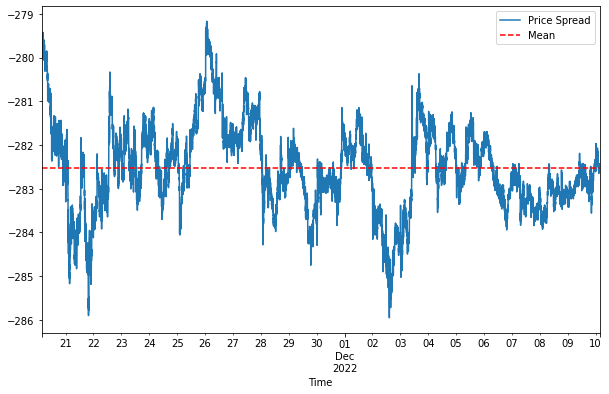

In [22]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])
plt.show()

In [23]:
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

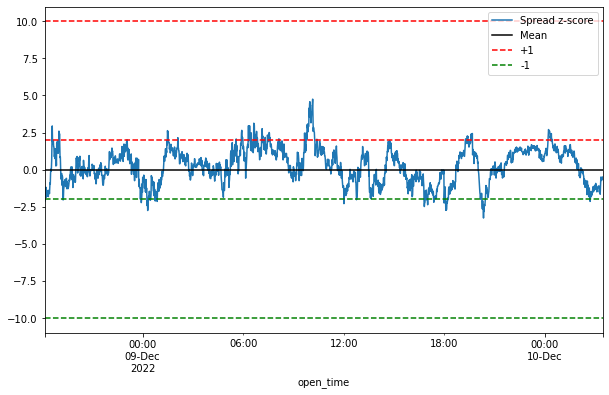

In [28]:
zscore(spread, half_life).tail(2000).plot()
plt.axhline(0, color='black')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.axhline(10, color='red', linestyle='--')
plt.axhline(-10, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])
plt.show()